# CREATING A INTELLIGENT AGENT TO PLAY FLAPPY BIRD

## SETTING THE ENVIRONMENT

Importing the pertinent libraries:

In [1]:
import random
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, LinearRegression

## EXPLORATORY DATA ANALYSIS

Loading the data:

In [2]:
data = pd.read_csv('../flappy_bean/data/new_flight_bean.csv')

data.head()

,x,y,label
0,518.5,17.5,False
1,513.5,35.5,False
2,508.5,50.5,False
3,503.5,59.5,False
4,498.5,59.5,False


General dataset information:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85769 entries, 0 to 85768
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       85769 non-null  float64
 1   y       85769 non-null  float64
 2   label   85769 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 1.4 MB


Transforming variables into numerical values and balancing the data:

In [4]:
data.label = data.label.map({False : 0, True : 1})

sampler = RandomUnderSampler()
data, _ = sampler.fit_resample(data, data.label)

Reduction of multiple samples with label 0:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23314 entries, 19714 to 85759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       23314 non-null  float64
 1   y       23314 non-null  float64
 2   label   23314 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 728.6 KB


Checking the data graphically:

Obs.: It can be seen that higher heights lead the bean not to jump to naturally reach gravity up to 0, while lower heights cause him to jump to reach the gap between the pipes.

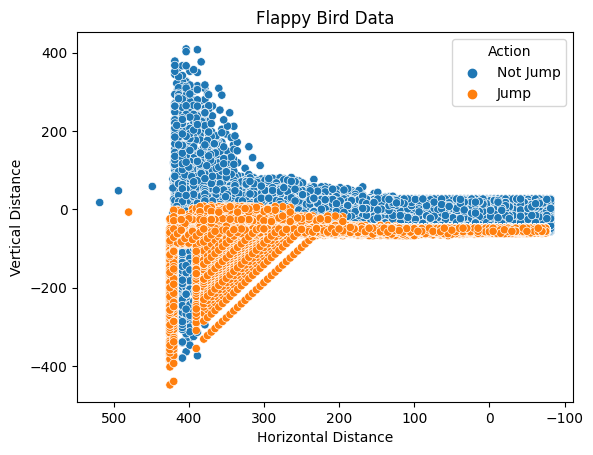

In [6]:
data['Action'] = data['label'].map({0 : 'Not Jump',
                                    1 : 'Jump'})

sns.scatterplot(data=data, x='x', y='y', hue='Action')

plt.title('Flappy Bird Data')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')

plt.gca().invert_xaxis()

plt.show()

Preparing the data for training:

Obs.: Since we'll be testing the models in the game's own environment, we won't split the data between training and testing.

In [7]:
X = data[['x', 'y']]
y = data.label

X_train = X.to_numpy()
y_train = y.to_numpy()

## LOGISTIC REGRESSION

Training a simple logistic regression model:

In [8]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

Evaluating the results:

In [9]:
print("Analyzing the results obtained with LogisticRegression:")

print()
print(f"Ein = {(1 - log_reg.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, log_reg.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, log_reg.predict(X_train)))

Analyzing the results obtained with LogisticRegression:

Ein = 13.11%

         h(x)=0  h(x)=+1
f(x)=0     9355     2302
f(x)=+1     755    10902

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     11657
           1       0.83      0.94      0.88     11657

    accuracy                           0.87     23314
   macro avg       0.88      0.87      0.87     23314
weighted avg       0.88      0.87      0.87     23314



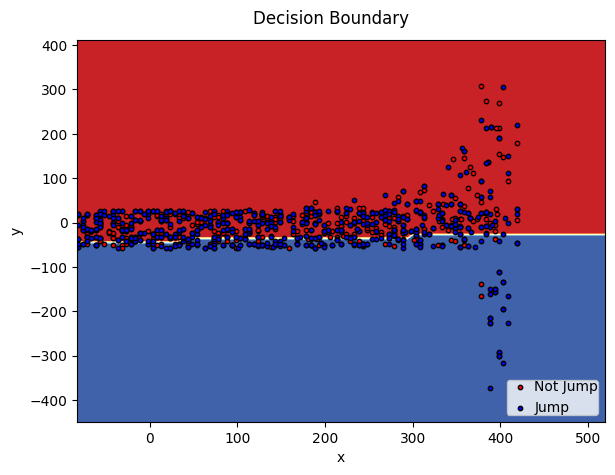

In [10]:
n_classes = 2
plot_colors = 'rb'
n_points = 1000

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=10
    )

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

There is a good accuracy in the training and the decision limits seem to be in accordance with what is expected for the problem, in the implementation of the game it is possible to see that this simple model of only 1 KB has become invincible.

Getting the line found by logistic regression:

In [11]:
b0 = log_reg.intercept_[0]
b1, b2 = log_reg.coef_.squeeze()

n_log = (0.5 - b0) / b2
m_log = (-b1) / b2

print(f'Intercept = {n_log}')
print(f'Coefficient = {m_log}')

f_logreg = lambda x: n_log + m_log * x

Intercept = -49.989899971104705
Coefficient = 0.03284468240242433


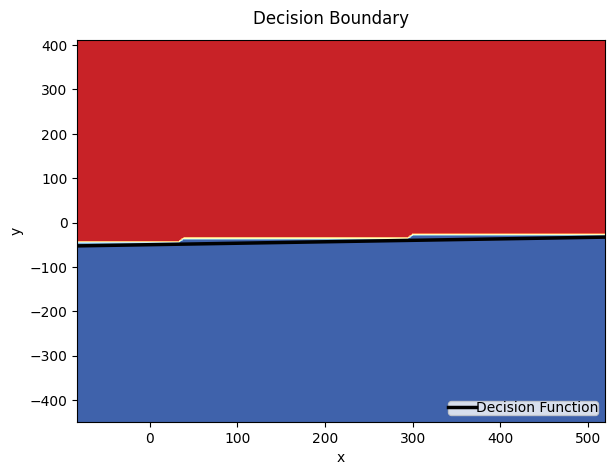

In [12]:
n_classes = 2
plot_colors = 'yb'
n_points = 1500

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

x_line = X['x'].min(), X['x'].max()
y_line = f_logreg(x_line[0]), f_logreg(x_line[1])
plt.plot(x_line, y_line, c='black', lw=2.5, label='Decision Function')

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Saving the model:

In [13]:
with open('../flappy_bean/models/log_reg.pkl','wb') as f:
    pickle.dump(log_reg, f)

## DECISION TREE CLASSIFIER

Training a decision tree model (the maximum depth of the tree was limited in order to obtain a less fragmented and more interpretable decision limit):

In [14]:
clf = DecisionTreeClassifier(max_depth=2)
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

n_alphas = 50
param_grid = {'ccp_alpha' : random.choices(ccp_alphas, k=n_alphas)}

CV_clf_tree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
CV_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'ccp_alpha': [0.0, 0.0075423265614016285,
                                       0.0075423265614016285, 0.0,
                                       0.30778947290549286, 0.30778947290549286,
                                       0.0075423265614016285,
                                       0.0075423265614016285, 0.0,
                                       0.30778947290549286,
                                       0.0075423265614016285,
                                       0.0075423265614016285,
                                       0.008738819720803745,
                                       0.008738819720803745,
                                       0.30778947290549286,
                                       0.008738819720803745,
                                       0.30778947290549286,
                                       0.0075423265614016285,
                                       0.008738819720803745,
                                       0.008738819720803745,
                                       0.0075423265614016285,
                                       0.008738819720803745,
                                       0.0075423265614016285,
                                       0.30778947290549286,
                                       0.008738819720803745,
                                       0.30778947290549286,
                                       0.0075423265614016285,
                                       0.30778947290549286, 0.30778947290549286,
                                       0.0, ...]})

Evaluating the results:

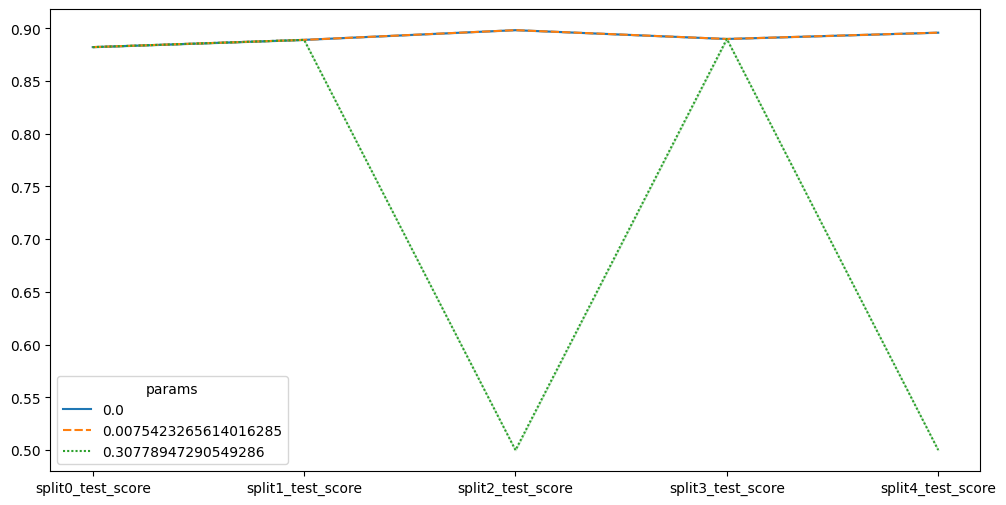

In [15]:
res = pd.DataFrame(CV_clf_tree.cv_results_)
res = res.sort_values(by=['rank_test_score'])
res = res.set_index(res['params'].apply(lambda x: x['ccp_alpha']))

plt.figure(figsize=(12, 6))

sns.lineplot(res.transpose().iloc[6:11, np.linspace(0, res.shape[0]-1, 5, dtype='int64')])

plt.show()

In [16]:
print("Getting the relevants features:")

print()

for i, v in enumerate(CV_clf_tree.best_estimator_.feature_importances_):
    if v:
        print(f"X[{i}] = {data.columns[i]} ({v})")

Getting the relevants features:

X[0] = x (0.023273712934257708)
X[1] = y (0.9767262870657423)


In [17]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Best parameters: {CV_clf_tree.best_estimator_}")

print()
print(f"Ein = {(1 - CV_clf_tree.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, CV_clf_tree.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, CV_clf_tree.predict(X_train)))

Analyzing the results obtained with DecisionTreeClassifier:

Best parameters: DecisionTreeClassifier(max_depth=2)

Ein = 10.87%

         h(x)=0  h(x)=+1
f(x)=0     9968     1689
f(x)=+1     846    10811

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     11657
           1       0.86      0.93      0.90     11657

    accuracy                           0.89     23314
   macro avg       0.89      0.89      0.89     23314
weighted avg       0.89      0.89      0.89     23314



At this point, we can see:

- The regularization parameter made little difference in the outcome of the training (demonstrating the quality of the data)
- Vertical distance has become the only important parameter in training (it determines the collision with the pipes and therefore with greater importance for the game)
- Recall 1 of 0.93 demonstrates that when it was supposed to actually jump, the model got it right reasonably

A key aspect in interpreting the model is plotting the decision region:

- As the data collected is limited to the game screen, it is presented in a well-defined way
- It can be seen that the x-axis is mirrored compared to the actual game
- The boundary between jumping or not jumping is close to 0, which represents the center of the gap between the pipes

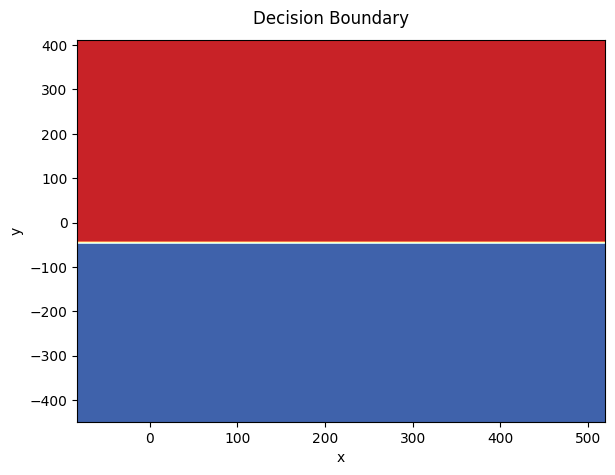

In [18]:
# Displaying the bounding region

clf_tree = CV_clf_tree.best_estimator_

ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    clf_tree,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

plt.suptitle('Decision Boundary')
_ = plt.axis('tight')

A simple and very interpretable tree can be plotted, we realize that the vertical distance limit of `-41.75` has become the only criterion for deciding whether to jump or not:

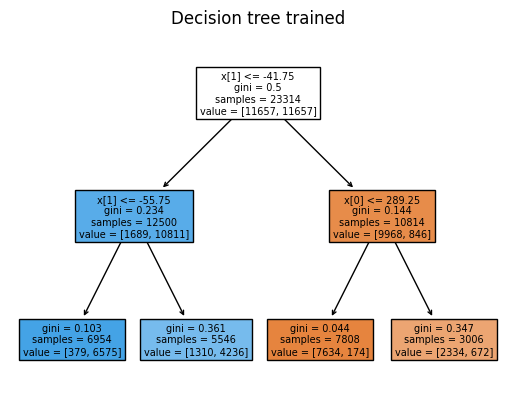

In [19]:
plot_tree(clf_tree, filled=True)

plt.title("Decision tree trained")

plt.show()

Saving the model:

In [20]:
with open('../flappy_bean/models/dtc.pkl','wb') as f:
    pickle.dump(clf_tree, f)

## SVM

Training an SVM with rbf kernel:

In [21]:
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)

SVC(probability=True)

Evaluating the results:

In [22]:
predict = svm_rbf.predict(X_train)

print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(pd.DataFrame(confusion_matrix(y_train, predict),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, predict))

Analyzing the results obtained with SupportVectorMachine:

         h(x)=0  h(x)=+1
f(x)=0     9453     2204
f(x)=+1     437    11220

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     11657
           1       0.84      0.96      0.89     11657

    accuracy                           0.89     23314
   macro avg       0.90      0.89      0.89     23314
weighted avg       0.90      0.89      0.89     23314



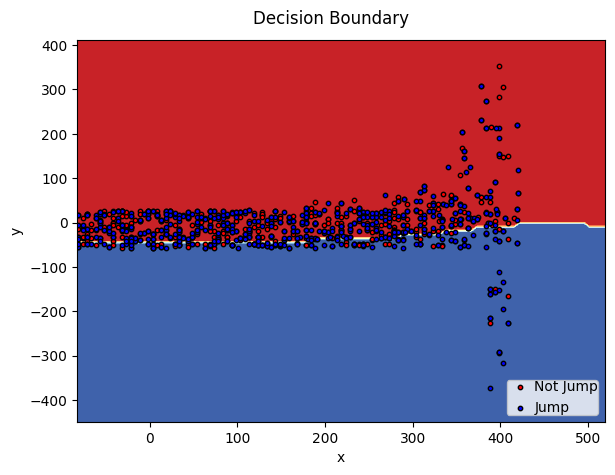

In [23]:
n_classes = 2
plot_colors = 'rb'
n_points = 1000

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_rbf,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y',
)

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=10
    )

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Obs.: Even though it is not a linear model, the `SVM` with `RBF` kernel has adjusted to a curve that approximates a straight line.

Approaching the curve of the decision boundary by a straight line. Initially, let's get the points that are exactly at the decision boundary:

In [24]:
init_a = -300
init_b = 400
epsilon = 0.00001

x_min = int(X['x'].min())
x_max = int(X['x'].max()) + 1

x_svm = list(range(x_min, x_max))
y_svm = list()

for x_i in x_svm:
    a = init_a
    b = init_b
    y_i = (a + b) / 2

    while abs(a - b) >= epsilon:
        pred_a = svm_rbf.predict_proba([[x_i, a]])[0][1]
        pred_b = svm_rbf.predict_proba([[x_i, b]])[0][1]
        pred_y = svm_rbf.predict_proba([[x_i, y_i]])[0][1]
        
        if 0.5 > pred_y:
            b = y_i
        else:
            a = y_i
            
        y_i = (a + b) / 2

    y_svm.append(y_i)

Displaying the points on the decision boundary:

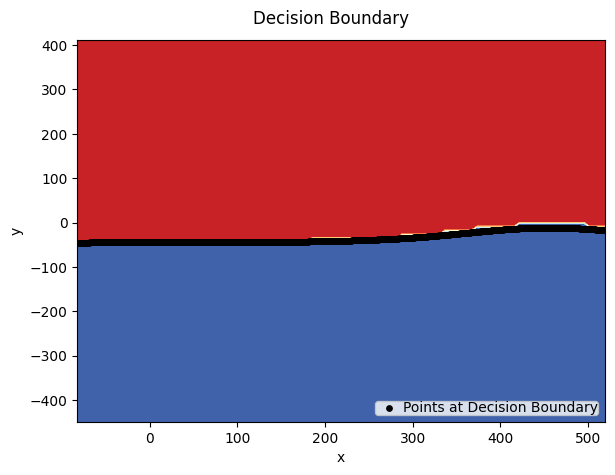

In [25]:
# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_rbf,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y',
)

# Displaying the points on the decision boundary
plt.scatter(
    x_svm,
    y_svm,
    c='black',
    label='Points at Decision Boundary',
    edgecolor='black',
    s=15
)

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Approaching the boundary by a hyperplane using the points obtained and the linear regression technique (in this case with few dimensions only a line):

In [26]:
x_svm = np.array(x_svm).reshape(-1, 1)
y_svm = np.array(y_svm).reshape(-1, 1)

lin_reg = LinearRegression()
lin_reg.fit(x_svm, y_svm)

LinearRegression()

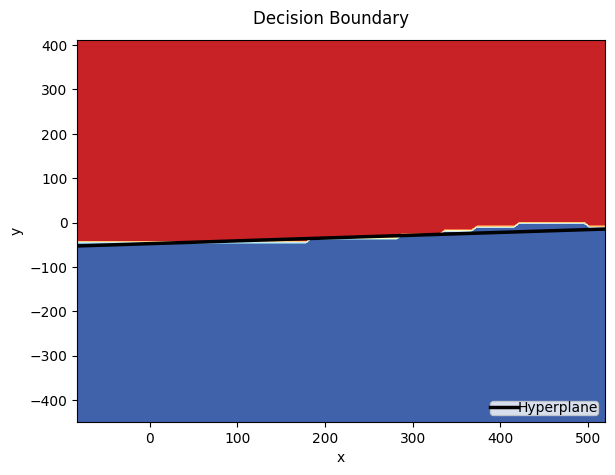

In [27]:
# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_rbf,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y',
)

x_line = x_min, x_max
y_line = lin_reg.predict([[x_line[0]]])[0][0], lin_reg.predict([[x_line[1]]])[0][0]
plt.plot(x_line, y_line, c='black', lw=2.5, label='Hyperplane')

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

It can be seen that we obtain a line similar to that of logistic regression, as follows:

In [28]:
print(f'Linear = {lin_reg.intercept_[0]}, Logistic = {n_log}')
print(f'Linear = {lin_reg.coef_[0][0]}, Logistic = {m_log}')

Linear = -47.62315881627478, Logistic = -49.989899971104705
Linear = 0.06340106801745175, Logistic = 0.03284468240242433


Saving the model:

In [29]:
with open('../flappy_bean/models/svm_rbf.pkl','wb') as f:
    pickle.dump(svm_rbf, f)